In [2]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from mpl_toolkits.axes_grid1 import AxesGrid, make_axes_locatable
from glob import glob
import xarray as xr
import pandas as pd
import numpy as np1
from pyresample import geometry, create_area_def
from satpy import Scene
from cartopy.mpl.geoaxes import GeoAxes
import cmocean
import cmocean.cm as cmo
import matplotlib.cm as cm
from matplotlib import ticker

In [5]:
#For daily combined files

extent = (-82.1, 24.3, -79.9, 25.7)

days = []
monthfiles = glob('/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/*')
monthfiles.sort()
for period in monthfiles:
    day = period[82:90]
    if day in days:
        continue
    elif day not in days:
        days.append(day)

for day in days:
    # Functions to be used
    files = glob('/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.'+ day +'*.L2.OC.x.nc')
    files.sort()
    print(files)
    def convtoxr(scn, var):
        #convert from dask array
        data = scn[var].load()
        data = data.where(data >= 0)
        data.name = var
        del(data.attrs['_satpy_id']) ### removing, we don't need this.
        data.attrs['area'] = str(data.attrs['area']) ### We may or may not need this in the future so converting it to a string
        return data

    def load_satdata(path, 
                     area_deff=None,
                     res=None,
                     name="GOMEX", proj={"proj": "laea"}, area_extent=extent,
                    ):
    #   get data and attributes
        data = xr.open_dataset(path, group='geophysical_data')
        navigation = xr.open_dataset(path, group='navigation_data')
        navigation = navigation.rename({'pixel_control_points': 'pixels_per_line'})
        attrs = xr.open_dataset(path).attrs

    #   area definition if not defined
        if res is None:
            # get the resolution of the Sat product
            val, unit = attrs['spatialResolution'].split()
            res  = xr.DataArray(float(val), attrs={"units": unit})
        if area_deff is None:
            area_deff = create_area_def(name, proj, area_extent=area_extent, units="degrees", resolution=res)

    #   reprojecting
        scn = Scene()
        swath_def = geometry.SwathDefinition(lons=navigation.longitude, lats= navigation.latitude)
        vnames = [v for v in data.data_vars if 'chlor_a' in v]
        for var in vnames:
            scn[var] = data[var]
            scn[var].attrs["area"] = swath_def
        resampled_scn = scn.resample(area_deff, radius_of_influence=int(res))
        resampled_scn.compute()
        lons, lats = resampled_scn[vnames[0]].attrs['area'].get_lonlats()
    #   Converting back to xarray dataset
        ds = xr.merge([convtoxr(resampled_scn, var) for var in vnames])
        ds.attrs = attrs
        ds = ds.assign_coords({
                                'lon': (('y', 'x'), lons),
                                'lat': (('y', 'x'), lats),
                                'time': pd.to_datetime(attrs['time_coverage_start'])
                                })
    #   getting rid of the crs coord
        ds = ds.drop('crs')
        print(str(ds.time.data))
        return ds

    # Area setup for GOMEX
    resval = 300 # resolution of the sat product (300 m for Sentinel and MERIS, 1 km for MODIS)
    res = xr.DataArray(resval, attrs={"units": "meters"})
    lat_0, lon_0 = 25, -81 # just some rounded up mean from the lat lon range of the sat product
    proj = {'proj': 'laea', 'lat_0': lat_0, 'lon_0': lon_0, 'a': 6371228.0, 'units': 'm'} # projection object
    area = create_area_def("FLBay", proj,
                           area_extent=extent, units="degrees", 
                           resolution=res
                          ) # creating a fixed area to reproject to

    # Reprojectig files
    dsets = [load_satdata(f, area_deff=area, res=res) for f in files] # looping trough the files
    combined = xr.concat(dsets, dim='time') #combining in one file


    #save combined file
    # give a sensible name i.e. cruiseID_satID.nc for every cruise and satelite

    savefile = '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel Chlorophyll/'+ day +'_SENTINEL_L2.nc'
    combined.to_netcdf(savefile) 

    
    

Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230101T145735.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230101T150335.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


2023-01-01T14:57:35.615000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-01-01T15:03:35.589000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230102T143124.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-01-02T14:31:24.923000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230103T140514.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230103T155213.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


2023-01-03T14:05:14.231000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-01-03T15:52:13.488000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230104T152602.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-01-04T15:26:02.796000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230105T145352.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230105T145952.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


2023-01-05T14:53:52.042000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-01-05T14:59:52.016000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230106T142741.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-01-06T14:27:41.262000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230107T140130.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230107T154829.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


2023-01-07T14:01:30.486000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-01-07T15:48:29.700000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230108T151618.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230108T152218.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


2023-01-08T15:16:18.901000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-01-08T15:22:18.876000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230109T145008.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-01-09T14:50:08.031000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230110T142357.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-01-10T14:23:57.159000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230111T135746.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230111T154445.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


2023-01-11T13:57:46.287000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-01-11T15:44:45.500000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230112T151234.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230112T151834.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


2023-01-12T15:12:34.565000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-01-12T15:18:34.539000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230113T144623.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-01-13T14:46:23.559000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230114T142012.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when convert

2023-01-14T14:20:12.554000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230115T135401.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230115T154100.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


2023-01-15T13:54:01.548000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-01-15T15:41:00.761000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230116T150849.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230116T151449.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


2023-01-16T15:08:49.649000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-01-16T15:14:49.667000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230117T144238.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-01-17T14:42:38.510000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230118T141627.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-01-18T14:16:27.546000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230119T153716.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-01-19T15:37:16.323000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230120T150505.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230120T151105.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


2023-01-20T15:05:05.779000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-01-20T15:11:05.797000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230121T143855.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-01-21T14:38:55.210000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230122T141244.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-01-22T14:12:44.640000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230123T153333.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-01-23T15:33:33.240000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230124T150122.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230124T150722.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


2023-01-24T15:01:22.564000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-01-24T15:07:22.538000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230125T143511.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-01-25T14:35:11.819000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230126T140901.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230126T155600.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2023-01-26T14:09:01.074000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-01-26T15:56:00.331000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230127T152949.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-01-27T15:29:49.585000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230128T145738.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230128T150338.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


2023-01-28T14:57:38.777000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-01-28T15:03:38.751000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230129T143127.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-01-29T14:31:27.943000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230130T140517.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230130T155216.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


2023-01-30T14:05:17.108000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-01-30T15:52:16.365000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230131T152605.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-01-31T15:26:05.530000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230201T145354.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230201T145954.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


2023-02-01T14:53:54.676000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-02-01T14:59:54.650000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230202T142743.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-02-02T14:27:43.753000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230203T140132.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230203T154832.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


2023-02-03T14:01:32.873000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-02-03T15:48:32.130000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230204T151621.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230204T152221.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


2023-02-04T15:16:21.187000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-02-04T15:22:21.205000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230205T145010.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-02-05T14:50:10.218000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230206T142359.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when convert

2023-02-06T14:23:59.248000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230207T135748.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230207T154447.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


2023-02-07T13:57:48.233000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-02-07T15:44:47.446000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230208T151236.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230208T151836.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


2023-02-08T15:12:36.412000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-02-08T15:18:36.387000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230209T144625.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-02-09T14:46:25.265000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230210T142014.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when convert

2023-02-10T14:20:14.117000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230211T135402.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230211T154102.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


2023-02-11T13:54:02.925000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-02-11T15:41:02.138000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230212T150850.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230212T151450.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


2023-02-12T15:08:50.884000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-02-12T15:14:50.858000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230213T144239.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-02-13T14:42:39.559000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230214T141628.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-02-14T14:16:28.191000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230215T153716.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-02-15T15:37:16.034000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230216T150504.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230216T151104.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


2023-02-16T15:05:04.778000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-02-16T15:11:04.796000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230217T143853.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-02-17T14:38:53.980000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230218T141243.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-02-18T14:12:43.182000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230219T153331.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-02-19T15:33:31.595000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230220T150120.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230220T150720.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


2023-02-20T15:01:20.689000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-02-20T15:07:20.707000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230221T143509.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-02-21T14:35:09.801000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230222T140858.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230222T155558.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2023-02-22T14:08:58.869000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-02-22T15:55:58.125000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230223T152947.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-02-23T15:29:47.149000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230224T145736.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230224T150336.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


2023-02-24T14:57:36.153000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-02-24T15:03:36.171000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230225T143125.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-02-25T14:31:25.132000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230226T140514.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230226T155213.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2023-02-26T14:05:14.111000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-02-26T15:52:13.323000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230227T152602.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-02-27T15:26:02.257000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230228T145351.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230228T145951.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


2023-02-28T14:53:51.086000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-02-28T14:59:51.104000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230301T142740.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-03-01T14:27:40.064000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230302T140129.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230302T154828.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


2023-03-02T14:01:29.527000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-03-02T15:48:28.827000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230303T151618.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230303T152218.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


2023-03-03T15:16:18.271000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-03-03T15:22:18.245000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230304T145007.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-03-04T14:50:07.646000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230305T142356.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when convert

2023-03-05T14:23:56.976000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230306T135746.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230306T154445.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


2023-03-06T13:57:46.262000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-03-06T15:44:45.518000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230307T151234.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230307T151834.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


2023-03-07T15:12:34.741000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-03-07T15:18:34.715000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230308T144623.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-03-08T14:46:23.856000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230309T142012.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when convert

2023-03-09T14:20:12.966000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230310T135402.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230310T154101.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


2023-03-10T13:54:02.031000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-03-10T15:41:01.242000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230311T150850.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230311T151450.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


2023-03-11T15:08:50.245000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-03-11T15:14:50.220000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230312T144239.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-03-12T14:42:39.134000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230313T141628.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-03-13T14:16:28.023000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230314T153716.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-03-14T15:37:16.298000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230315T150505.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230315T151105.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


2023-03-15T15:05:05.959000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-03-15T15:11:05.977000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230316T143855.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-03-16T14:38:55.594000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230317T141245.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-03-17T14:12:45.185000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230318T153334.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-03-18T15:33:34.076000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230319T150123.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230319T150723.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


2023-03-19T15:01:23.605000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-03-19T15:07:23.579000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230320T143513.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-03-20T14:35:13.107000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230321T140902.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230321T155601.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2023-03-21T14:09:02.566000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-03-21T15:56:01.866000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230322T152951.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-03-22T15:29:51.281000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230323T145740.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230323T150340.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


2023-03-23T14:57:40.677000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-03-23T15:03:40.695000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230324T143130.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-03-24T14:31:30.003000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230325T140519.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230325T155218.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2023-03-25T14:05:19.284000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-03-25T15:52:18.540000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230326T152607.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-03-26T15:26:07.778000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230327T145356.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230327T145956.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


2023-03-27T14:53:56.953000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-03-27T14:59:56.972000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230328T142746.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-03-28T14:27:46.103000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230329T140135.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230329T154834.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


2023-03-29T14:01:35.253000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-03-29T15:48:34.509000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230330T151623.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230330T152223.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


2023-03-30T15:16:23.596000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-03-30T15:22:23.614000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230331T145012.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-03-31T14:50:12.614000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230401T142401.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-04-01T14:24:01.633000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230402T135750.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230402T154449.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


2023-04-02T13:57:50.607000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-04-02T15:44:49.818000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230403T151238.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230403T151838.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


2023-04-03T15:12:38.774000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-04-03T15:18:38.748000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230404T144627.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-04-04T14:46:27.616000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230405T142016.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-04-05T14:20:16.677000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230406T135406.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230406T154105.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


2023-04-06T13:54:06.134000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-04-06T15:41:05.390000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230407T150854.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230407T151454.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


2023-04-07T15:08:54.786000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-04-07T15:14:54.804000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230408T144244.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-04-08T14:42:44.155000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230409T141633.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-04-09T14:16:33.524000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230410T153722.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-04-10T15:37:22.105000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230411T150511.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230411T151111.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


2023-04-11T15:05:11.367000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-04-11T15:11:11.385000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230412T143900.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-04-12T14:39:00.602000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230413T141249.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-04-13T14:12:49.839000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230414T153338.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-04-14T15:33:38.331000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230415T150127.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230415T150727.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


2023-04-15T15:01:27.461000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-04-15T15:07:27.479000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230416T143516.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-04-16T14:35:16.566000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230417T140905.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230417T155604.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2023-04-17T14:09:05.671000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-04-17T15:56:04.882000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230418T152953.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-04-18T15:29:53.943000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230419T145742.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230419T150342.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


2023-04-19T14:57:42.940000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-04-19T15:03:42.914000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230420T143131.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-04-20T14:31:31.859000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230421T140520.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230421T155220.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2023-04-21T14:05:20.829000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-04-21T15:52:20.040000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230422T152608.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-04-22T15:26:08.924000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230423T145357.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230423T145957.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


2023-04-23T14:53:57.789000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-04-23T14:59:57.763000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230424T142746.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-04-24T14:27:46.540000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230425T140135.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230425T154834.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


2023-04-25T14:01:35.292000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-04-25T15:48:34.504000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230426T151623.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230426T152223.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


2023-04-26T15:16:23.413000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-04-26T15:22:23.387000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230427T145012.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-04-27T14:50:12.692000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230428T142401.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when convert

2023-04-28T14:24:01.926000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230429T135751.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230429T154450.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


2023-04-29T13:57:51.204000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-04-29T15:44:50.460000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230430T151239.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230430T151839.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


2023-04-30T15:12:39.676000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-04-30T15:18:39.650000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230501T144628.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-05-01T14:46:28.823000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230502T142018.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-05-02T14:20:18.014000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230503T135407.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230503T154106.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


2023-05-03T13:54:07.160000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-05-03T15:41:06.416000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230504T150855.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230504T151455.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


2023-05-04T15:08:55.500000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-05-04T15:14:55.518000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230505T144244.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-05-05T14:42:44.601000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230506T141633.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-05-06T14:16:33.620000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230507T153721.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-05-07T15:37:21.890000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230508T150510.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230508T151110.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


2023-05-08T15:05:10.885000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-05-08T15:11:10.903000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230509T143859.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-05-09T14:38:59.810000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230510T141248.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-05-10T14:12:48.734000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230511T153336.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-05-11T15:33:36.869000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230512T150125.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230512T150725.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


2023-05-12T15:01:25.731000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-05-12T15:07:25.705000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230513T143514.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-05-13T14:35:14.523000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230514T140903.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230514T155602.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2023-05-14T14:09:03.315000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-05-14T15:56:02.526000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230515T152951.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-05-15T15:29:51.317000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230516T145740.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230516T150340.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


2023-05-16T14:57:40.222000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-05-16T15:03:40.196000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230517T143129.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-05-17T14:31:29.497000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230518T140518.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230518T155218.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


2023-05-18T14:05:18.815000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-05-18T15:52:18.070000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230519T152607.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-05-19T15:26:07.345000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230520T145356.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230520T145956.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


2023-05-20T14:53:56.601000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-05-20T14:59:56.575000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230521T142745.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-05-21T14:27:45.786000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230522T140135.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230522T154834.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


2023-05-22T14:01:35.013000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-05-22T15:48:34.224000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230523T151623.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230523T152223.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


2023-05-23T15:16:23.390000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-05-23T15:22:23.408000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230524T145012.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-05-24T14:50:12.485000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230525T142401.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-05-25T14:24:01.625000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230526T135750.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230526T154449.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


2023-05-26T13:57:50.720000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-05-26T15:44:49.931000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230527T151239.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230527T151838.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


2023-05-27T15:12:39.008000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-05-27T15:18:38.982000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230528T144628.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-05-28T14:46:28.014000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230529T142017.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-05-29T14:20:17.066000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230530T135406.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230530T154105.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


2023-05-30T13:54:06.073000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-05-30T15:41:05.284000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230531T150854.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230531T151454.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


2023-05-31T15:08:54.273000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-05-31T15:14:54.291000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230601T144243.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-06-01T14:42:43.236000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230602T141632.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-06-02T14:16:32.154000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230603T153720.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-06-03T15:37:20.283000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230604T150509.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230604T151109.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


2023-06-04T15:05:09.183000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-06-04T15:11:09.201000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230605T143858.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-06-05T14:38:58.013000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230606T141246.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-06-06T14:12:46.842000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230607T153334.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-06-07T15:33:34.883000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230608T150123.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230608T150723.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


2023-06-08T15:01:23.650000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-06-08T15:07:23.668000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230609T143512.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-06-09T14:35:12.392000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230610T140901.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230610T155600.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2023-06-10T14:09:01.132000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-06-10T15:56:00.343000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230611T152949.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-06-11T15:29:49.040000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230612T145737.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230612T150337.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


2023-06-12T14:57:37.719000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-06-12T15:03:37.737000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230613T143126.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-06-13T14:31:26.370000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230614T140515.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230614T155214.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2023-06-14T14:05:15.199000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-06-14T15:52:14.454000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230615T152603.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-06-15T15:26:03.766000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230616T145353.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230616T145953.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


2023-06-16T14:53:53.017000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-06-16T14:59:53.035000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230617T142742.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-06-17T14:27:42.241000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230618T140131.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230618T154830.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


2023-06-18T14:01:31.464000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-06-18T15:48:30.675000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230619T151619.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230619T152219.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


2023-06-19T15:16:19.880000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-06-19T15:22:19.898000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230620T145009.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-06-20T14:50:09.015000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230621T142358.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-06-21T14:23:58.106000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230622T135747.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230622T154446.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


2023-06-22T13:57:47.240000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-06-22T15:44:46.451000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230623T151235.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230623T151835.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


2023-06-23T15:12:35.522000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-06-23T15:18:35.540000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230624T144624.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-06-24T14:46:24.568000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230625T142013.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when convert

2023-06-25T14:20:13.568000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230626T135402.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230626T154101.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


2023-06-26T13:54:02.524000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-06-26T15:41:01.778000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230627T150850.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230627T151450.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


2023-06-27T15:08:50.716000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-06-27T15:14:50.690000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230628T144239.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-06-28T14:42:39.628000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230629T141628.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-06-29T14:16:28.496000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230630T153716.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-06-30T15:37:16.617000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230701T150505.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230701T151105.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


2023-07-01T15:05:05.510000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-07-01T15:11:05.484000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230702T143854.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-07-02T14:38:54.332000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230703T141243.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-07-03T14:12:43.155000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230704T153331.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-07-04T15:33:31.194000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230705T150120.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230705T150720.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


2023-07-05T15:01:20.087000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-07-05T15:07:20.105000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230706T143509.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-07-06T14:35:09.305000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230707T140858.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230707T155557.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2023-07-07T14:08:58.480000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-07-07T15:55:57.734000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230708T152946.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-07-08T15:29:46.908000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230709T145736.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230709T150336.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


2023-07-09T14:57:36.021000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-07-09T15:03:36.039000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230710T143125.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-07-10T14:31:25.150000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230711T140514.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230711T155213.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2023-07-11T14:05:14.280000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-07-11T15:52:13.490000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230712T152602.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-07-12T15:26:02.620000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230713T145351.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230713T145951.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


2023-07-13T14:53:51.687000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-07-13T14:59:51.661000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230714T142740.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-07-14T14:27:40.684000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230715T140129.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230715T154828.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


2023-07-15T14:01:29.725000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-07-15T15:48:28.979000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230716T151617.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230716T152217.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


2023-07-16T15:16:17.959000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-07-16T15:22:17.977000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230717T145006.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-07-17T14:50:06.956000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230718T142355.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-07-18T14:23:55.866000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230719T135744.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230719T154444.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


2023-07-19T13:57:44.818000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-07-19T15:44:44.028000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230720T151232.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230720T151832.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


2023-07-20T15:12:32.919000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-07-20T15:18:32.937000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230721T144621.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-07-21T14:46:21.785000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230722T142010.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-07-22T14:20:10.606000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230723T135359.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230723T154058.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


2023-07-23T13:53:59.428000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-07-23T15:40:58.638000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230724T150847.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230724T151447.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


2023-07-24T15:08:47.441000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-07-24T15:14:47.415000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230725T144236.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-07-25T14:42:36.175000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230726T141624.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-07-26T14:16:24.908000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230727T153712.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-07-27T15:37:12.939000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230728T150502.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230728T151102.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


2023-07-28T15:05:02.006000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-07-28T15:11:02.024000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230729T143851.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-07-29T14:38:51.047000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230730T141240.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-07-30T14:12:40.044000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230731T153328.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-07-31T15:33:28.339000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230801T150117.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230801T150717.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


2023-08-01T15:01:17.449000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-08-01T15:07:17.423000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230802T143506.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-08-02T14:35:06.490000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230803T140855.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230803T155554.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2023-08-03T14:08:55.575000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-08-03T15:55:54.785000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230804T152943.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-08-04T15:29:43.827000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230805T145732.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230805T150332.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


2023-08-05T14:57:32.807000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-08-05T15:03:32.781000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230806T143121.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-08-06T14:31:21.761000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230807T140510.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230807T155209.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2023-08-07T14:05:10.707000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-08-07T15:52:09.916000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230808T152558.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-08-08T15:25:58.817000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230809T145347.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230809T145947.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


2023-08-09T14:53:47.707000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-08-09T14:59:47.725000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230810T142736.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-08-10T14:27:36.573000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230811T140125.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230811T154824.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


2023-08-11T14:01:25.439000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-08-11T15:48:24.649000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230812T151613.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230812T152213.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


2023-08-12T15:16:13.497000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-08-12T15:22:13.471000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230813T145002.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-08-13T14:50:02.274000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230814T142351.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when convert

2023-08-14T14:23:51.052000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230815T135739.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230815T154439.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


2023-08-15T13:57:39.830000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-08-15T15:44:39.041000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230816T151227.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230816T151827.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


2023-08-16T15:12:27.801000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-08-16T15:18:27.819000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230817T144616.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-08-17T14:46:16.712000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230818T142006.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when convert

2023-08-18T14:20:06.019000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230819T135355.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230819T154054.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


2023-08-19T13:53:55.370000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-08-19T15:40:54.580000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230820T150843.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230820T151443.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


2023-08-20T15:08:43.869000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-08-20T15:14:43.887000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230821T144233.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-08-21T14:42:33.132000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230822T141622.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-08-22T14:16:22.352000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230823T153710.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-08-23T15:37:10.825000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230824T150500.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230824T151100.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


2023-08-24T15:05:00.027000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-08-24T15:11:00.045000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230825T143849.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-08-25T14:38:49.159000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230826T141238.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-08-26T14:12:38.336000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230827T153326.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-08-27T15:33:26.723000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230828T150115.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230828T150715.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


2023-08-28T15:01:15.839000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-08-28T15:07:15.857000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230829T143504.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-08-29T14:35:04.929000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230830T140854.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230830T155553.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2023-08-30T14:08:54.019000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-08-30T15:55:53.230000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230831T152942.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-08-31T15:29:42.409000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230901T145731.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230901T150331.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


2023-09-01T14:57:31.878000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-09-01T15:03:31.896000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230902T143121.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-09-02T14:31:21.321000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230903T140510.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230903T155210.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


2023-09-03T14:05:10.721000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-09-03T15:52:10.019000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230904T152559.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-09-04T15:25:59.375000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230905T145348.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230905T145948.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


2023-09-05T14:53:48.757000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-09-05T14:59:48.731000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230906T142738.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-09-06T14:27:38.070000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230907T140127.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230907T154826.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


2023-09-07T14:01:27.428000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-09-07T15:48:26.683000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230908T151616.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230908T152215.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


2023-09-08T15:16:16.023000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-09-08T15:22:15.997000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230909T145005.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-09-09T14:50:05.293000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230910T142354.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-09-10T14:23:54.563000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230911T135743.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230911T154443.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


2023-09-11T13:57:43.834000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-09-11T15:44:43.045000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230912T151232.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230912T151832.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


2023-09-12T15:12:32.299000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-09-12T15:18:32.273000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230913T144621.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-09-13T14:46:21.439000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230914T142010.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when convert

2023-09-14T14:20:10.580000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230915T135359.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230915T154058.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


2023-09-15T13:53:59.721000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-09-15T15:40:58.976000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230916T150848.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230916T151448.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


2023-09-16T15:08:48.056000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-09-16T15:14:48.074000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230917T144237.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-09-17T14:42:37.110000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230918T141626.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-09-18T14:16:26.121000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230919T153714.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-09-19T15:37:14.388000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230920T150503.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230920T151103.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


2023-09-20T15:05:03.294000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-09-20T15:11:03.312000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230921T143852.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-09-21T14:38:52.218000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230922T141241.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-09-22T14:12:41.098000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230923T153329.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-09-23T15:33:29.191000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230924T150118.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230924T150718.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


2023-09-24T15:01:18.011000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-09-24T15:07:18.029000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230925T143506.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-09-25T14:35:06.807000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230926T140855.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230926T155554.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2023-09-26T14:08:55.559000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-09-26T15:55:54.770000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230927T152943.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-09-27T15:29:43.699000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230928T145733.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230928T150333.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


2023-09-28T14:57:33.182000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-09-28T15:03:33.201000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230929T143122.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-09-29T14:31:22.641000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230930T140512.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20230930T155211.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2023-09-30T14:05:12.063000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-09-30T15:52:11.319000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20231001T152600.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-10-01T15:26:00.691000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20231002T145350.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20231002T145950.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


2023-10-02T14:53:50.045000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-10-02T14:59:50.019000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20231003T142739.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-10-03T14:27:39.329000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20231004T140128.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20231004T154827.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


2023-10-04T14:01:28.615000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-10-04T15:48:27.827000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20231005T151617.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20231005T152217.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


2023-10-05T15:16:17.052000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-10-05T15:22:17.070000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20231006T145006.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-10-06T14:50:06.207000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20231007T142355.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-10-07T14:23:55.319000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20231008T135744.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20231008T154443.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


2023-10-08T13:57:44.432000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-10-08T15:44:43.644000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20231009T151232.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20231009T151832.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


2023-10-09T15:12:32.695000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-10-09T15:18:32.713000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20231010T144621.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-10-10T14:46:21.677000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20231011T142010.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when convert

2023-10-11T14:20:10.614000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20231012T135359.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20231012T154058.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


2023-10-12T13:53:59.553000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-10-12T15:40:58.765000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20231013T150847.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20231013T151447.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


2023-10-13T15:08:47.598000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-10-13T15:14:47.616000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20231014T144236.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-10-14T14:42:36.404000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20231015T141625.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-10-15T14:16:25.163000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20231016T153713.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-10-16T15:37:13.316000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20231017T150502.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20231017T151102.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


2023-10-17T15:05:02.767000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-10-17T15:11:02.785000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20231018T143852.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-10-18T14:38:52.193000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20231019T141241.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-10-19T14:12:41.620000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20231020T153330.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-10-20T15:33:30.215000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20231021T150119.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20231021T150719.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


2023-10-21T15:01:19.537000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-10-21T15:07:19.555000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20231022T143508.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-10-22T14:35:08.832000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20231023T140858.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20231023T155557.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2023-10-23T14:08:58.085000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-10-23T15:55:57.342000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20231024T152946.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-10-24T15:29:46.551000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20231025T145735.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20231025T150335.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


2023-10-25T14:57:35.788000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-10-25T15:03:35.762000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20231026T143124.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-10-26T14:31:24.956000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20231027T140514.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20231027T155213.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2023-10-27T14:05:14.124000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-10-27T15:52:13.337000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20231028T152602.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-10-28T15:26:02.463000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20231029T145351.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20231029T145951.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


2023-10-29T14:53:51.525000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-10-29T14:59:51.544000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20231030T142740.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-10-30T14:27:40.563000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20231031T140129.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20231031T154828.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


2023-10-31T14:01:29.557000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-10-31T15:48:28.770000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20231101T151617.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20231101T152217.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


2023-11-01T15:16:17.569000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-11-01T15:22:17.588000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20231102T145006.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-11-02T14:50:06.344000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20231103T142355.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-11-03T14:23:55.075000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20231104T135743.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20231104T154443.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


2023-11-04T13:57:43.806000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-11-04T15:44:43.020000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20231105T151231.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20231105T151831.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


2023-11-05T15:12:31.690000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-11-05T15:18:31.708000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20231106T144620.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-11-06T14:46:20.246000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20231107T142008.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when convert

2023-11-07T14:20:08.715000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20231108T135357.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20231108T154056.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


2023-11-08T13:53:57.184000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-11-08T15:40:56.354000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20231109T150845.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20231109T151445.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


2023-11-09T15:08:45.026000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-11-09T15:14:45.044000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20231110T144234.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-11-10T14:42:34.332000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20231111T141623.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-11-11T14:16:23.595000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20231112T153712.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-11-12T15:37:12.072000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20231113T150501.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20231113T151101.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


2023-11-13T15:05:01.274000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-11-13T15:11:01.292000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20231114T143850.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-11-14T14:38:50.449000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20231115T141239.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-11-15T14:12:39.580000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20231116T153327.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-11-16T15:33:27.969000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20231117T150117.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20231117T150717.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


2023-11-17T15:01:17.039000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-11-17T15:07:17.057000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20231118T143506.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-11-18T14:35:06.128000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20231119T140855.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20231119T155554.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


2023-11-19T14:08:55.172000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-11-19T15:55:54.430000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20231120T152943.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-11-20T15:29:43.476000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20231121T145732.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20231121T150332.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


1970-01-01T00:00:00.000000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


1970-01-01T00:00:00.000000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20231122T143121.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-11-22T14:31:21.416000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20231123T140510.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20231123T155209.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2023-11-23T14:05:10.374000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-11-23T15:52:09.588000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20231124T152558.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-11-24T15:25:58.503000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20231125T145347.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20231125T145947.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


2023-11-25T14:53:47.356000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-11-25T14:59:47.330000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20231126T142736.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-11-26T14:27:36.095000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20231127T140124.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20231127T154824.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


2023-11-27T14:01:24.834000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-11-27T15:48:24.048000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20231128T152212.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-11-28T15:22:12.838000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20231129T145002.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-11-29T14:50:02.043000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20231130T142351.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters


2023-11-30T14:23:51.266000000
['/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20231201T135740.L2.OC.x.nc', '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/S3A_OLCI_EFRNT.20231201T154439.L2.OC.x.nc']


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


2023-12-01T13:57:40.666000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


2023-12-01T15:44:39.880000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


In [36]:
#For monthly combined files

extent = (-82.1, 24.3, -79.9, 25.7)
month = 'Aug_2023'



# Functions to be used
files = glob('/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel/'+month+'/S3A_OLCI_EFRNT.*.L2.OC.x.nc')
files.sort()
def convtoxr(scn, var):
    #convert from dask array
    data = scn[var].load()
    data = data.where(data >= 0)
    data.name = var
    del(data.attrs['_satpy_id']) ### removing, we don't need this.
    data.attrs['area'] = str(data.attrs['area']) ### We may or may not need this in the future so converting it to a string
    return data

def load_satdata(path, 
                 area_deff=None,
                 res=None,
                 name="GOMEX", proj={"proj": "laea"}, area_extent=extent,
                ):
#   get data and attributes
    data = xr.open_dataset(path, group='geophysical_data')
    navigation = xr.open_dataset(path, group='navigation_data')
    navigation = navigation.rename({'pixel_control_points': 'pixels_per_line'})
    attrs = xr.open_dataset(path).attrs

#   area definition if not defined
    if res is None:
        # get the resolution of the Sat product
        val, unit = attrs['spatialResolution'].split()
        res  = xr.DataArray(float(val), attrs={"units": unit})
    if area_deff is None:
        area_deff = create_area_def(name, proj, area_extent=area_extent, units="degrees", resolution=res)

#   reprojecting
    scn = Scene()
    swath_def = geometry.SwathDefinition(lons=navigation.longitude, lats= navigation.latitude)
    vnames = [v for v in data.data_vars if 'chlor_a' in v]
    for var in vnames:
        scn[var] = data[var]
        scn[var].attrs["area"] = swath_def
    resampled_scn = scn.resample(area_deff, radius_of_influence=int(res))
    resampled_scn.compute()
    lons, lats = resampled_scn[vnames[0]].attrs['area'].get_lonlats()
#   Converting back to xarray dataset
    ds = xr.merge([convtoxr(resampled_scn, var) for var in vnames])
    ds.attrs = attrs
    ds = ds.assign_coords({
                            'lon': (('y', 'x'), lons),
                            'lat': (('y', 'x'), lats),
                            'time': pd.to_datetime(attrs['time_coverage_start'])
                            })
#   getting rid of the crs coord
    ds = ds.drop('crs')
    print(str(ds.time.data))
    return ds

# Area setup for FLBay
resval = 300 # resolution of the sat product (300 m for Sentinel and MERIS, 1 km for MODIS)
res = xr.DataArray(resval, attrs={"units": "meters"})
lat_0, lon_0 = 25, -81 # just some rounded up mean from the lat lon range of the sat product
proj = {'proj': 'laea', 'lat_0': lat_0, 'lon_0': lon_0, 'a': 6371228.0, 'units': 'm'} # projection object
area = create_area_def("FLBay", proj,
                       area_extent=extent, units="degrees", 
                       resolution=res
                      ) # creating a fixed area to reproject to

# Reprojectig files
dsets = [load_satdata(f, area_deff=area, res=res) for f in files] # looping trough the files
combined = xr.concat(dsets, dim='time') #combining in one file


#save combined file
# give a sensible name i.e. cruiseID_satID.nc for every cruise and satelite

savefile = '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel Chlorophyll/'+month+'/'+ month +'_SENTINEL_L2.nc'
combined.to_netcdf(savefile) 


    

Rounding shape to (519, 739) and resolution from (300.0, 300.0) meters to (299.9990744565843, 299.95812550371795) meters
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when convert

2023-09-01T15:03:31.896000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


2023-09-03T15:52:10.019000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


2023-09-04T15:25:59.375000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


2023-09-05T14:59:48.731000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


2023-09-07T15:48:26.683000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


2023-09-08T15:22:15.997000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


2023-09-11T15:44:43.045000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


2023-09-12T15:18:32.273000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


2023-09-15T15:40:58.976000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


2023-09-16T15:14:48.074000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


2023-09-19T15:37:14.388000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


2023-09-20T15:11:03.312000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


2023-09-23T15:33:29.191000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


2023-09-24T15:07:18.029000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


2023-09-26T15:55:54.770000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


2023-09-27T15:29:43.699000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


2023-09-28T15:03:33.201000000
2023-09-30T15:52:11.319000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


In [ ]:
cfile = glob('/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel Chlorophyll/Sep_2022/*_SENTINEL_L2.nc')
cfile.sort()

extent = (-81.8, -80.2, 24.55, 25.45)

resval = 300 # resolution of the sat product (300 m for Sentinel and MERIS, 1 km for MODIS)
res = xr.DataArray(resval, attrs={"units": "meters"})

projection = ccrs.PlateCarree()


for file in cfile:
    fig = plt.figure(figsize=(9,6))
    ax = fig.add_subplot(1,1,1,
                     projection=ccrs.LambertConformal())    
    day = file[79:87]
    ds = xr.open_dataset(file)
    data = ds.chlor_a.mean('time')

    im = data.where(data!=0).plot(ax=ax, vmin=0, vmax=20, 
                                  x='lon', y='lat', 
                                  add_colorbar=False,
                                 transform=ccrs.PlateCarree(),
                                 cmap='viridis_r')
    ax.coastlines()
    ax.set_extent(extent)
    ax.add_feature(cfeature.NaturalEarthFeature(category='physical', 
                                                name='land',
                                                facecolor='grey', # change color here
                                                scale='10m')) 
    ax.add_feature(cfeature.NaturalEarthFeature(category='physical', 
                                                name='rivers_lake_centerlines',
                                                edgecolor='blue', # change color here
                                                facecolor='none',
                                            scale='10m'))
    gl = ax.gridlines(crs=ccrs.PlateCarree(),
         ylocs=[24.5, 25, 25.5, 30], 
         xlocs=[-80.5, -81, -81.5], 
         draw_labels=True, linewidth=1, color='k', alpha=0.5, linestyle='--', x_inline=False, y_inline=False)
    gl.right_labels = False
    gl.top_labels = False

    ax.set_title(day[0:4]+'-'+day[4:6]+'-'+day[6:8], fontsize=13.5)
    cb = fig.colorbar(im, ax=ax, shrink=0.8, extend='both', pad=0.02)
    cb.set_label('Concentration Chlor-a (mg m$^{-3}$)', size=13.5)
    fig.savefig('/home/hboi-ouri/Projects/NASA_ProjectExp/outputs/Chlorophyll/Sentinel FLBay/'+day+'SentinelChlorophyll.png')
        
# title = ['January 2022', 'February 2022', 'March 2022', 'April 2022', 'May 2022', 'June 2022',
#          'July 2022', 'August 2022', 'September 2022', 'October 2022', 'November 2022', 'December 2022']

    
# fig.suptitle(year+' Chlorophyll-a Concentration', size=18)


/tmp/ipykernel_47471/3460623683.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(9,6))


In [15]:
file = '/home/hboi-ouri/Projects/RS_Files/Chlorophyll/CruiseRaw/FA2021/AQUA_MODIS.20211022T181500.L2.OC.x.nc'


day = file[79:87]
data = xr.open_dataset(file, group='geophysical_data')

data.data_vars


Data variables:
    aot_869   (number_of_lines, pixels_per_line) float32 ...
    angstrom  (number_of_lines, pixels_per_line) float32 ...
    Rrs_412   (number_of_lines, pixels_per_line) float32 ...
    Rrs_443   (number_of_lines, pixels_per_line) float32 ...
    Rrs_469   (number_of_lines, pixels_per_line) float32 ...
    Rrs_488   (number_of_lines, pixels_per_line) float32 ...
    Rrs_531   (number_of_lines, pixels_per_line) float32 ...
    Rrs_547   (number_of_lines, pixels_per_line) float32 ...
    Rrs_555   (number_of_lines, pixels_per_line) float32 ...
    Rrs_645   (number_of_lines, pixels_per_line) float32 ...
    Rrs_667   (number_of_lines, pixels_per_line) float32 ...
    Rrs_678   (number_of_lines, pixels_per_line) float32 ...
    chlor_a   (number_of_lines, pixels_per_line) float32 ...
    Kd_490    (number_of_lines, pixels_per_line) float32 ...
    pic       (number_of_lines, pixels_per_line) float32 ...
    poc       (number_of_lines, pixels_per_line) float32 ...
    ipar

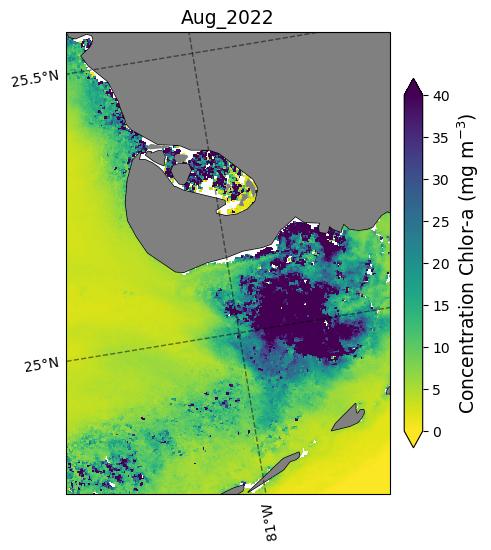

In [44]:
cfile = glob('/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel Chlorophyll/Aug_2022/*_SENTINEL_L2.nc')
cfile.sort()

# extent = (-81.8, -80.2, 24.55, 25.45) 
# Mason extent:
extent = (-81.25, -80.75, 24.75, 25.5)
# 24.75 N to 25.5 N and 80.75W to 81.25W

resval = 300 # resolution of the sat product (300 m for Sentinel and MERIS, 1 km for MODIS)
res = xr.DataArray(resval, attrs={"units": "meters"})

projection = ccrs.PlateCarree()


for file in cfile:
    fig = plt.figure(figsize=(9,6))
    ax = fig.add_subplot(1,1,1,
                     projection=ccrs.LambertConformal())    
    day = file.split('/')[8]
    ds = xr.open_dataset(file)
    data = ds.chlor_a.mean('time')

    im = data.where(data!=0).plot(ax=ax, vmin=0, vmax=40, 
                                  x='lon', y='lat', 
                                  add_colorbar=False,
                                 transform=ccrs.PlateCarree(),
                                 cmap='viridis_r')
    ax.coastlines()
    ax.set_extent(extent)
    ax.add_feature(cfeature.NaturalEarthFeature(category='physical', 
                                                name='land',
                                                facecolor='grey', # change color here
                                                scale='10m')) 
    ax.add_feature(cfeature.NaturalEarthFeature(category='physical', 
                                                name='rivers_lake_centerlines',
                                                edgecolor='blue', # change color here
                                                facecolor='none',
                                            scale='10m'))
    gl = ax.gridlines(crs=ccrs.PlateCarree(),
         ylocs=[24.5, 25, 25.5, 30], 
         xlocs=[-80.5, -81, -81.5], 
         draw_labels=True, linewidth=1, color='k', alpha=0.5, linestyle='--', x_inline=False, y_inline=False)
    gl.right_labels = False
    gl.top_labels = False

    ax.set_title(day, fontsize=13.5)
    cb = fig.colorbar(im, ax=ax, shrink=0.8, extend='both', pad=0.02)
    cb.set_label('Concentration Chlor-a (mg m$^{-3}$)', size=13.5)
    fig.savefig('/home/hboi-ouri/Projects/NASA_ProjectExp/outputs/Chlorophyll/Sentinel FLBay/'+day+'/'+day+'SentinelChlorophyll.png')
        
# title = ['January 2022', 'February 2022', 'March 2022', 'April 2022', 'May 2022', 'June 2022',
#          'July 2022', 'August 2022', 'September 2022', 'October 2022', 'November 2022', 'December 2022']

    
# fig.suptitle(year+' Chlorophyll-a Concentration', size=18)


# cfile = glob('/home/hboi-ouri/Projects/RS_Files/Chlorophyll/FLBay_Hanna/Sentinel Chlorophyll/Sep_2022/*_SENTINEL_L2.nc')
cfile.sort()

extent = (-81.8, -80.2, 24.55, 25.45)

resval = 300 # resolution of the sat product (300 m for Sentinel and MERIS, 1 km for MODIS)
res = xr.DataArray(resval, attrs={"units": "meters"})

projection = ccrs.PlateCarree()


for file in cfile:
    fig = plt.figure(figsize=(9,6))
    ax = fig.add_subplot(1,1,1)    
    day = file.split('/')[8]
    ds = xr.open_dataset(file)
    data = ds.chlor_a.mean('time')

    ax.hist(data.where(data!=0))
    ax.set_xlabel('Time (in seconds)')